# Rossmann sales forecasting

## Description
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their **daily sales** for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
#### **Métrica de evaluacion: Root Mean Square Percentage Error (RMSPE)**

Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as

***raiz(promedio(cuadrado((y_real - y_pred) / y_real)))***

where y_i denotes the sales of a single store on a single day and yhat_i denotes the corresponding prediction. ***Any day and store with 0 sales is ignored in scoring***.

#### Importación de paquetes necesarios

In [1]:
# Paquetes más generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import warnings
import copy
from datetime import datetime, timedelta
import time
import pickle

# Paquetes para modelado
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA

#### Carga de archivos

In [2]:
## Setear acá directorio necesario
path = r'C:\Users\lucas.veteikis\Desktop\Lucas\Facu\Machine Learning'
os.chdir(path)
print(os.getcwd())

c:\Users\lucas.veteikis\Desktop\Lucas\Facu\Machine Learning


In [205]:
test_id = 'test.csv'
train_id = 'train.csv'
store_id = 'store.csv'
euri3m_id = 'euribor3m.csv'
eurimonth_id = 'euriborpromedio.csv'
train = pd.read_csv(train_id, parse_dates=True, low_memory=False)
store = pd.read_csv(store_id, parse_dates=True, low_memory=False)
test = pd.read_csv(test_id, parse_dates=True, low_memory= False)

# Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Notas
* **Open** (Train)
	* Es una variable que toma 1 o 0. Siempre que toma el valor 0, la variable dependiente Sales es 0, ya que la tienda estaba cerrada y no se vende nada ese dia
    * Solucion: Una opcion puede ser que cuando `Open==0`, siempre `Sales==0`, y que solo le pasemos al modelo para que prediga cuando `Open==1`
		* De todas formas no cuenta para la performance lo que se predice cuando las ventas reales son 0 (no se puede calcular un error porcentual)
* **CompetitionOpenSinceYear** (Store)
	* Tiene dos valores inusualmente bajos en comparacion con los demas valores de la columna, probablemente sean erroneos.
    * Solucion: Se convierten a NaN los dos valores outliers. Luego hay que tomar algun criterio para rellenarlos, por ejemplo la media o la mediana y sumar otra columna que registre que eran NaN
* **Assortment** (Store)
	* Cateogria ordenada: parece tener poder predictivo
* **StateHoliday** (Train)
	* Cateogria
* **StoreType** (Store)
	* Categoria: parece tener poder predictivo
* **Date** (Train)
	* Se crean muchas columnas a partir de la fecha: `Year`, `Month`, `Day`, `Semana`, `IsWeekend`, `PrimeraQuincena`, `SegundaQuincena`, `ComienzaAnio`, `TerminaAnio`, `Mesanio`
* **Promo2** (Store)
	* La verdad hasta el momento no entiendo muy bien que es, pero podriamos consultarlo
	* Se crea la columna `IsPromo2Month` que dice si el mes es alguno de los que dice la columna `Promo2Interval`

# Definición de funciones

In [206]:
# Funcion que toma una fila y crea una nueva columna numerica concatenando el año y semana de Promo2
def yearweek(df, columnayear, columnaweek):
  df = df[df[columnayear].notna() & df[columnayear].notna()].copy()
  df[columnayear] = df[columnayear].astype(int)
  df[columnaweek] = df[columnaweek].astype(int)
  df['yearweekfunc'] = df.apply(lambda row: int(str(row[columnayear]) + (str(row[columnaweek]) if row[columnaweek] >= 10 else ('0' + str(row[columnaweek])))), axis=1)
  return df[['yearweekfunc']]

### Funciones de modelado

In [207]:
## Definición de función para calcular métrica de interés
def rmspe(y_true, y_pred):
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    relevantes = np.where(y_true == 0, False, True)
    rmspe = (np.sqrt(np.mean(np.square((y_true[relevantes] - y_pred[relevantes]) / y_true[relevantes]))))
    return rmspe

# Calculo del sesgo de lo predicho respecto de lo real
def bias(y_true, y_pred):
    return np.mean(np.array(y_pred) - np.array(y_true))


In [208]:
def n_samples(n, boundaries):
    samp = copy.deepcopy(boundaries)
    for key in samp:
        samp[key].clear()
    for i in range(n):
        for key in samp:
            func = boundaries[key][0]
            args = boundaries[key][1]
            samp[key].append(func(*args))
    return samp

In [209]:
def entrena_evalua(algoritmo, x_train, y_train, x_valid, y_valid, hparam_sample):
    # Registro del momento de comienzo
    start_time = time.time()
    # Creacion y entrenamiento del algoritmo
    model = algoritmo(**hparam_sample)
    if algoritmo == xgb.XGBRegressor:
        model.fit(x_train, y_train, eval_set=[(x_valid, np.array(y_valid))], verbose=False)#, eval_metric=mean_squared_error)
    else:
        model.fit(x_train, y_train)
    # Se usa el modelo para predecir train y valid y se calculan los errores
    y_pred_train = pd.Series(model.predict(x_train))
    y_pred_train.to_pickle('y_pred_train.pkl')
    rmspe_train = rmspe(y_train, y_pred_train)
    y_pred = pd.Series(model.predict(x_valid))
    rmspe_val = rmspe(y_valid, y_pred)
    # Calculo del sesgo
    sesgo_val = bias(y_valid, y_pred)
    ajuste_sesgo = 1 - (sesgo_val / np.mean(y_valid))
    rmspe_val_ajuste_sesgo = rmspe(y_valid, y_pred * ajuste_sesgo)
    # Registro del momento de finalizacion
    stop_time = time.time()
    # Se registran las columnas que tendra el dataframe que retornara la funcion
    columns = list(hparam_sample.keys())
    columns.extend(['rmspe_train', 'rmspe_val', 'sesgo_val', 'ajuste_sesgo', 'rmspe_val_ajust_sesgo', 'algoritmo', 'tiempo_min'])
    if algoritmo == xgb.XGBRegressor:
        columns.extend(['best_ntree_limit'])
    # Se registran la info que tendra el dataframe que retornara la funcion
    data = []
    for key in hparam_sample:
        data.append(hparam_sample[key])
    data.extend([rmspe_train, rmspe_val, sesgo_val, ajuste_sesgo, rmspe_val_ajuste_sesgo, algoritmo.__name__, round((stop_time - start_time)/60, 1)])
    if algoritmo == xgb.XGBRegressor:
        data.extend([model.best_ntree_limit])
    return pd.DataFrame(data=[data], columns=columns), model

In [210]:
def hyper_search(algoritmo, x_train, y_train, x_valid, y_valid, minutos=1, hparam_n_samples=dict(), file_path='archivo.csv'):
    with open(f'hparam_samples_{algoritmo.__name__}.txt', 'w') as archivo:
            for key in hparam_n_samples:
                archivo.write(f'{key}: {hparam_n_samples[key]}\n\n')
    # Inicializamos variables relevantes para el while
    n = len(hparam_n_samples[list(hparam_n_samples.keys())[0]])
    i = 0
    hasta = datetime.today() + timedelta(minutes=minutos)
    print(f"Comienza el proceso de random search hasta llegar a {n} modelos o {minutos} minutos disponibles")
    print(f"Ahora: {datetime.today()}\nFinalización aproximada: {hasta}")
    # Se inicializa la lista de modelos con el indice que tendrá en el dataframe, el modelo en si y el rmspe_valid
    modelos = []
    errores = []
    indices = []
    # El loop se ejecuta hasta que se cumpla el tiempo o que se recorra todo el sampleo con exito, lo que suceda antes
    while datetime.today() < hasta and i < n:
        # Populamos el diccionario hparams con las variables 
        hparams = dict()
        for key in hparam_n_samples:
            hparams[key] = hparam_n_samples[key][i]
        try:
            # Entrenamiento del modelo
            resultado, modelo = entrena_evalua(algoritmo, x_train, y_train, x_valid, y_valid, hparam_sample=hparams)
            # Se suman los modelos y su info a las listas de los modelos que quedan como los 5 mejores
            modelos.append(modelo)
            errores.append(resultado.loc[0, 'rmspe_val'])
            indices.append(i)
            # Se guarda el resultado del ultimo modelo en el dataframe que va acumulando la info de los modelos.
            if i == 0:
                dataframe = resultado.copy()
            else:
                dataframe = pd.concat([dataframe, resultado])
            # Guardamos el dataset con todos los modelos corridos hasta el momento para qeu cuando crashee no se pierda lo ya hecho
            dataframe.to_csv(file_path)
            i += 1
        except xgb.core.XGBoostError as err:
            # Esta parte del código se ejecutará si se lanza la excepción
            print(f"Ocurrió un error: {err}")
            print(f"Los hiperparámetros con los que falló el código son:\n{hparams}")
            for key in hparam_n_samples:
                hparam_n_samples[key].pop(i)
        # Nos quedamos siempre con los mejores 20 modelos
        if len(modelos) > 20:
            # Posicion en las listas del peor modelo segun rmspe_valid
            indice_remove = errores.index(max(errores))
            # Se elimina el peor modelo
            modelos.pop(indice_remove)
            errores.pop(indice_remove)
            indices.pop(indice_remove)
        if (i) % 5 == 0:
            print(f"Modelo {i} terminado. Quedan {n-i} modelos por correr o {int((hasta - datetime.today()).total_seconds() / 60)} minutos. ({datetime.today()})")
    else:
        # Chequeamos por que se salio del while y lo informamos al usuario
        if datetime.today() >= hasta:
            print(f'Se acabo el tiempo el tiempo, se procesaron {i} modelos')
        elif i >= n:
            print(f'Termino el proceso por haber recorrido los {n} modelos')
    mejores_modelos = [indices, modelos, errores]
    return dataframe, mejores_modelos

In [211]:
def graficar_rand_search(random_search):
    columnas = list(random_search.columns)
    remover = ['random_state', 'n_jobs', 'bootstrap', 'algoritmo']
    for item in remover:
        if item in columnas:
            columnas.remove(item)

    graficar = random_search[columnas]
    for col in columnas:
        if col == 'rmspe_val':
            pass
        elif graficar.dtypes[col] in ['int64', 'float64']:
            plt.scatter(graficar[col], graficar['rmspe_val'], s=10, alpha=0.7)
            # Configurar los ejes
            plt.xlabel(col)
            plt.ylabel('VALID RMSPE')
            plt.show()
        elif graficar.dtypes[col] in ['object']:
            # Agrupar los valores de "rmspe_val" por categoría de "criterion"
            grouped_data = graficar.groupby(col)['rmspe_val'].apply(list)

            # Crear una lista de etiquetas y una lista de valores para el boxplot
            labels = grouped_data.index.tolist()
            values = grouped_data.tolist()
            plt.boxplot(values, labels=labels)
            # Configurar los ejes
            plt.xlabel(col)
            plt.ylabel('VALID RMSPE')
            plt.show()

In [212]:
def feat_importance(top_models, df):
    for i in range(len(top_models[0])):
        print(f"Modelo {top_models[0][i]}: rmspe en validacion de {top_models[2][i]}")
        print('Feature Importance')
        feature_imp = pd.DataFrame({'feature':df.columns, 'importance':top_models[1][i].feature_importances_}).sort_values('importance', ascending=False)
        print(feature_imp)

In [213]:
def retrain_and_predict(x_train, y_train,x_valid,y_valid,x_test,top_models,rmspe_threshold):
    '''
    Función para reentrenar y predecir
    Inputs: 
    - x_train, y_train 
    - x_valid, y_valid
    - Los datos de testeo para que prediga (x_test)
    - La lista de modelos que vamos a usar, que es el output de la función hyper_search (es una lista de listas)
    - rmspe_threshold --> Cuanto debe haber sacado como máximo de puntaje RMSPE el modelo en validación para ser considerado

    Outputs:
    - Dataframe con el promedio de las predicciones de los modelos considerados (según la lista que se le pase y el treshold)
    '''
    ## Generamos full x y full y para reentrenar con datos completos
    full_x = pd.concat([x_train,x_valid])
    full_y = pd.concat([y_train,y_valid])

    #Procesamiento de test
    id = x_test['Id']
    x_test = x_test.drop(columns='Id')

    ## Reentrenamiento de los modelos con toda la data
    predictions = pd.DataFrame()
    for i in range(len(top_models[1])):
        if top_models[2][i] <= rmspe_threshold:
            print(f'Entrenando modelo {i}')
            top_models[1][i].fit(full_x, full_y)
            predictions[f'Predictions_{i}'] = top_models[1][i].predict(x_test)
            print(f'Modelo {i} fitteado')

    predictions_mean = predictions.mean(axis=1) #Promedio de predicciones

    return predictions_mean

## Data Processing

In [214]:
train.drop(['Customers'], axis=1, inplace=True) ## Droppeo columna que forma parte de otro problema de predicción
train.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,1,1,0,1
1,2,5,2015-07-31,6064,1,1,0,1
2,3,5,2015-07-31,8314,1,1,0,1
3,4,5,2015-07-31,13995,1,1,0,1
4,5,5,2015-07-31,4822,1,1,0,1


In [215]:
test['Sales'] = np.nan #No quiero que tenga un valor, en NA esta bien
test['Kaggle'] = True ## Me marco estos que son los que van para kaggle

In [216]:
print(train['Sales'].isna().sum()) ## En el train no tengo NA en sales, me viene bien
train['Kaggle'] = False

0


In [217]:
set(test.columns) - set(train.columns)
#El único que me falta es Id, que es irrelevante en train, concat lo va a llenar con NA

{'Id'}

In [218]:
df = pd.concat([train,test]) #Df con train + test diferenciados, para aplicar transformaciones

In [219]:
# Hay que convertir Date a fecha y State Holiday a categoria. Las otras categorias son ya 1s y 0s, asique no haria falta
print(df.columns)
print(df.info())

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Kaggle', 'Id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Store          1058297 non-null  int64  
 1   DayOfWeek      1058297 non-null  int64  
 2   Date           1058297 non-null  object 
 3   Sales          1017209 non-null  float64
 4   Open           1058286 non-null  float64
 5   Promo          1058297 non-null  int64  
 6   StateHoliday   1058297 non-null  object 
 7   SchoolHoliday  1058297 non-null  int64  
 8   Kaggle         1058297 non-null  bool   
 9   Id             41088 non-null    float64
dtypes: bool(1), float64(3), int64(4), object(2)
memory usage: 81.8+ MB
None


In [220]:
# Se convierte Date a fecha y StateHoliday a categorica
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df['StateHoliday'] = df['StateHoliday'].astype('category')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1058297 non-null  int64         
 1   DayOfWeek      1058297 non-null  int64         
 2   Date           1058297 non-null  datetime64[ns]
 3   Sales          1017209 non-null  float64       
 4   Open           1058286 non-null  float64       
 5   Promo          1058297 non-null  int64         
 6   StateHoliday   1058297 non-null  category      
 7   SchoolHoliday  1058297 non-null  int64         
 8   Kaggle         1058297 non-null  bool          
 9   Id             41088 non-null    float64       
dtypes: bool(1), category(1), datetime64[ns](1), float64(3), int64(4)
memory usage: 74.7 MB
None


## Preprocesamiento de store.csv

In [221]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [222]:
## Visualizando los intervalos de la promo2
print(store['PromoInterval'].unique())
store.groupby(store['PromoInterval'])['Store'].count().reset_index()

[nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


,PromoInterval,Store
0,"Feb,May,Aug,Nov",130
1,"Jan,Apr,Jul,Oct",335
2,"Mar,Jun,Sept,Dec",106


In [223]:
#Estadisticos básicos de la distancia de la competencia
print(store[store['CompetitionDistance'].notna()]['CompetitionDistance'].median())
print(store[store['CompetitionDistance'].notna()]['CompetitionDistance'].mean())

2325.0
5404.901079136691


1900.0
2015.0
2008.6688567674114
2010.0


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   5.,   4.,  81., 287., 382.]),
 array([1900.  , 1905.75, 1911.5 , 1917.25, 1923.  , 1928.75, 1934.5 ,
        1940.25, 1946.  , 1951.75, 1957.5 , 1963.25, 1969.  , 1974.75,
        1980.5 , 1986.25, 1992.  , 1997.75, 2003.5 , 2009.25, 2015.  ]),
 <BarContainer object of 20 artists>)

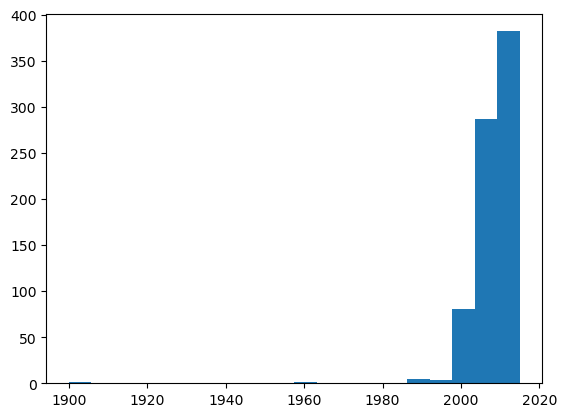

In [224]:
## Visualización del feature CompetitionOpenSinceYear
print(store['CompetitionOpenSinceYear'].min())
print(store['CompetitionOpenSinceYear'].max())
print(store['CompetitionOpenSinceYear'].mean())
print(store['CompetitionOpenSinceYear'].median())
plt.hist(store['CompetitionOpenSinceYear'], bins=20)

Hay dos datos de CompetitionOpenSinceYear que son outliers que no tienen sentido. Quizas lo mejor seria directamente quedarse con NaN en esos 2 casos y despues tratarlos como NaN (rellenando el valor y creando una columna que indique cuales valores eran NaN)

In [225]:
# Se convierten a NaN esos valores que son menores a 1990. Total esta columna ahora tiene 5 NaN, que luego habrá que rellenar
store['CompetitionOpenSinceYear'] = np.where(store['CompetitionOpenSinceYear'] < 1990, np.nan, store['CompetitionOpenSinceYear'])
store['CompetitionOpenSinceMonth'] = np.where(store['CompetitionOpenSinceYear'] < 1990, np.nan, store['CompetitionOpenSinceMonth'])

In [226]:
# Se convierte las columnas StoreType y Assortment a categorias
store['StoreType'] = store['StoreType'].astype('category')
store['Assortment'] = store['Assortment'].astype('category')
assortments = 'a', 'b', 'c'
store['Assortment'] = store['Assortment'].cat.set_categories(assortments, ordered=True)

### Mergeo de los dos dataframes procesados

In [227]:
original_df = df.copy()
df = df.merge(store, how='left', left_on='Store', right_on='Store', suffixes=("","_stores"))

In [228]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 1058296
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1058297 non-null  int64         
 1   DayOfWeek                  1058297 non-null  int64         
 2   Date                       1058297 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  float64       
 4   Open                       1058286 non-null  float64       
 5   Promo                      1058297 non-null  int64         
 6   StateHoliday               1058297 non-null  category      
 7   SchoolHoliday              1058297 non-null  int64         
 8   Kaggle                     1058297 non-null  bool          
 9   Id                         41088 non-null    float64       
 10  StoreType                  1058297 non-null  category      
 11  Assortment                 1058297 no

In [229]:
df.to_pickle('merged_dataset.pkl')

# EDA

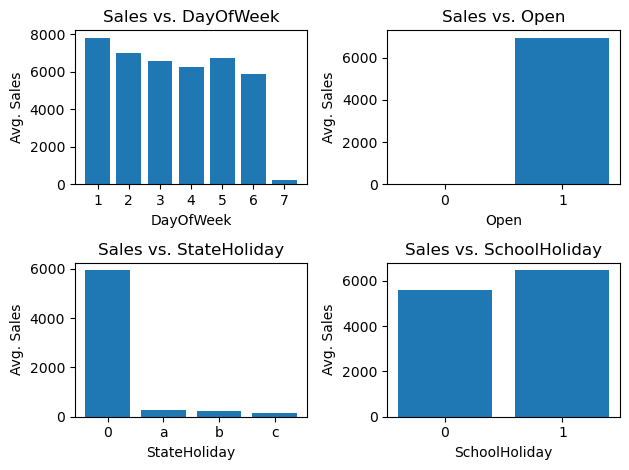

In [230]:
# Se plotean 4 variables para ver como varia Sales en cada una de ellas
fig, axs = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]}, layout='tight')

# Columnas a graficar
cols = ['DayOfWeek', 'Open', 'StateHoliday', 'SchoolHoliday']

# Diccionario para elegir subplot
ax = dict()
n = 0
for i in range(2):
    for j in range(2):
        ax[n] = [i,j]
        n += 1

# Se recorre las 4 columnas a graficar contra Sales
for i in range(len(cols)):
    subtabla = df[df['Kaggle'] == False].groupby(cols[i])['Sales'].mean().reset_index()
    axs[ax[i][0], ax[i][1]].bar(subtabla[cols[i]], subtabla['Sales'])
    axs[ax[i][0], ax[i][1]].set_xlabel(cols[i])
    axs[ax[i][0], ax[i][1]].set_ylabel('Avg. Sales')
    axs[ax[i][0], ax[i][1]].set_title(f'Sales vs. {cols[i]}')
    axs[ax[i][0], ax[i][1]].set_xticks(subtabla[cols[i]])

plt.show()

In [231]:
# En el caso de Open, si la tienda esta cerrada nunca tiene ventas (la columna parece fidedigna). Quizas para el modelo
# podriamos considerar hardcodearla (si Open=0 entonces Sales=0, pero si Open=1 entonces que prediga el modelo)
print(df[df['Kaggle'] == False].groupby(['Open'])['Sales'].mean().reset_index())
print()
print('Casos de Open=0 con Ventas:')
print(df[(df['Kaggle'] == False) & (df['Open']==0) & (df['Sales']>0)].shape[0])

   Open        Sales
0   0.0     0.000000
1   1.0  6955.514291

Casos de Open=0 con Ventas:
0


#### Exploración temporal del dataset
Importante para detectar estacionalidad

In [232]:
# Desde que fecha y hasta que fecha va el Dataset?
print('Periodo de entrenamiento:')
print(df[df['Kaggle'] == False]['Date'].min())
print(df[df['Kaggle'] == False]['Date'].max())
print('Periodo de test:')
print(df[df['Kaggle']]['Date'].min())
print(df[df['Kaggle']]['Date'].max())

Periodo de entrenamiento:
2013-01-01 00:00:00
2015-07-31 00:00:00
Periodo de test:
2015-08-01 00:00:00
2015-09-17 00:00:00


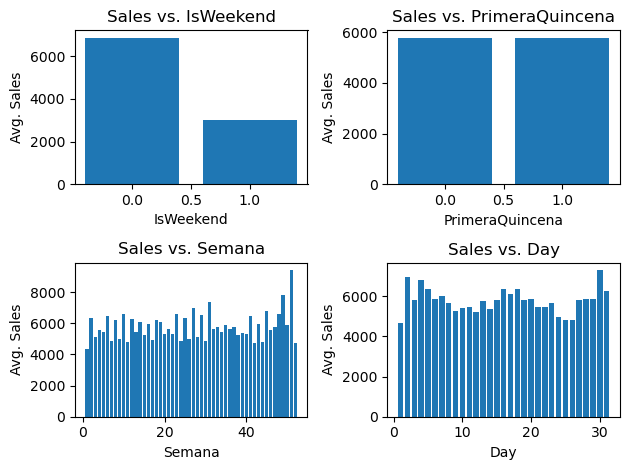

In [233]:
### Para hacer este plot, me paso 4 variables del feature engineering para acá ###
df['IsWeekend'] = df['DayOfWeek'].isin([6, 7])
df['Day'] = df['Date'].dt.day
df['PrimeraQuincena'] = (1 <= df['Date'].dt.day) & (df['Date'].dt.day <= 15)
df['Semana'] = df['Date'].dt.isocalendar().week.astype('int')

#Ahora, se plotean 4 variables para ver como varia Sales en cada una de ellas
fig, axs = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]}, layout='tight')

# Columnas a graficar
cols = ['IsWeekend', 'PrimeraQuincena', 'Semana', 'Day']

# Diccionario para elegir subplot
ax = dict()
n = 0
for i in range(2):
    for j in range(2):
        ax[n] = [i,j]
        n += 1

# Se recorre las 4 columnas a graficar contra Sales
for i in range(len(cols)):
    subtabla = df[df['Kaggle'] == False].groupby(cols[i])['Sales'].mean().reset_index()
    axs[ax[i][0], ax[i][1]].bar(subtabla[cols[i]], subtabla['Sales'])
    axs[ax[i][0], ax[i][1]].set_xlabel(cols[i])
    axs[ax[i][0], ax[i][1]].set_ylabel('Avg. Sales')
    axs[ax[i][0], ax[i][1]].set_title(f'Sales vs. {cols[i]}')

plt.show()

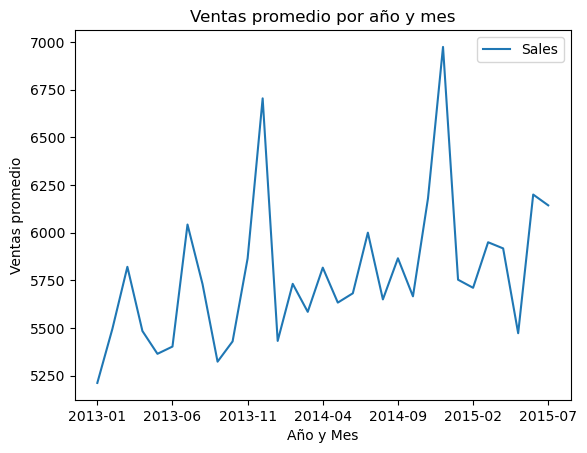

In [234]:
### Para hacer este plot, me paso algunas variables del feature engineering para acá ###
df['Year'] = df['Date'].dt.year 
df['Month'] = df['Date'].dt.month
df['Mesanio'] = df['Year'].astype(str) + '-' + df['Month'].apply(lambda x: '0'+str(x) if x <= 9 else str(x))


## Gráficamos 
df_grouped = df.groupby('Mesanio')['Sales'].mean().reset_index()
df_grouped.plot('Mesanio','Sales')
plt.title('Ventas promedio por año y mes')
plt.xlabel('Año y Mes')
plt.ylabel('Ventas promedio')
plt.show()

C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\1498668581.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(subtabla_2013.index, rotation=90)
C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\1498668581.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(subtabla_2014.index, rotation=90)
C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\1498668581.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(subtabla_2015.index, rotation=90)


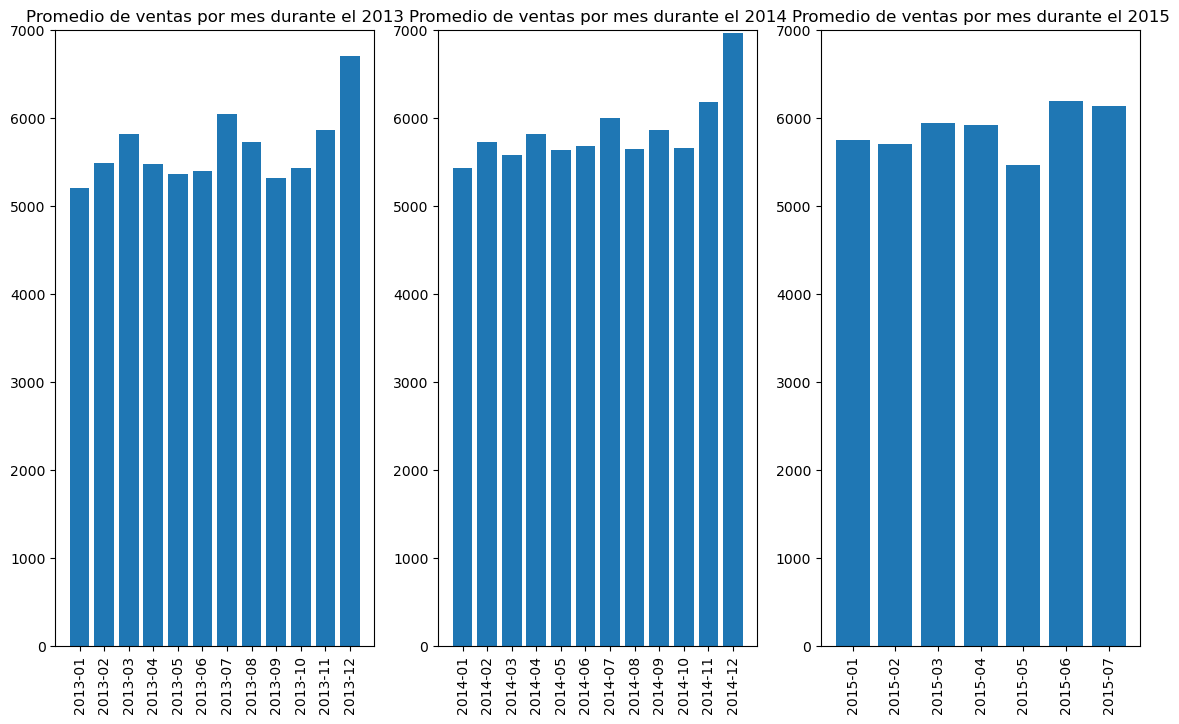

In [235]:
#Plot de ventas mensuales por mes de cada año

subtabla = pd.DataFrame(df[df['Kaggle'] == False].groupby('Mesanio')['Sales'].mean())
subtabla_2013 = subtabla[subtabla.index < '2014-01']
subtabla_2014 = subtabla[(subtabla.index >= '2014-01') & (subtabla.index <= '2014-12')]
subtabla_2015 = subtabla[subtabla.index >= '2015-01']
fig, ax = plt.subplots(1,3,figsize=(14,8))


ax[0].bar(subtabla_2013.index, subtabla_2013['Sales'])
ax[0].set_title('Promedio de ventas por mes durante el 2013')
ax[0].set_xticklabels(subtabla_2013.index, rotation=90)
ax[0].set_ylim(0,7000)

ax[1].bar(subtabla_2014.index, subtabla_2014['Sales'])
ax[1].set_title('Promedio de ventas por mes durante el 2014')
ax[1].set_xticklabels(subtabla_2014.index, rotation=90)
ax[1].set_ylim(0,7000)

ax[2].bar(subtabla_2015.index, subtabla_2015['Sales'])
ax[2].set_title('Promedio de ventas por mes durante el 2015')
ax[2].set_xticklabels(subtabla_2015.index, rotation=90)
ax[2].set_ylim(0,7000)

plt.show()

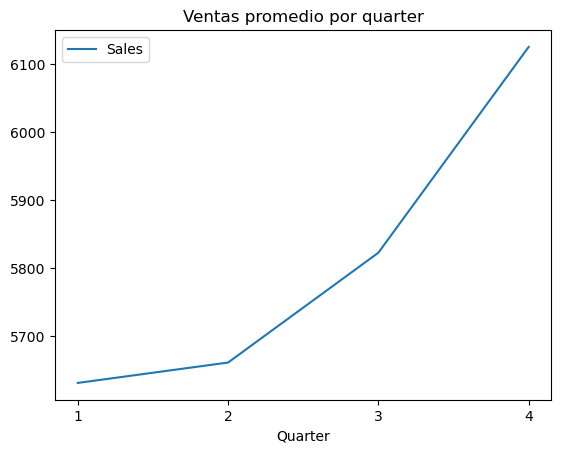

In [236]:
## Mismo análisis, pero por quarter
## Creo variable de Quarter ##
df['Quarter'] = df['Date'].dt.quarter

## Plot
subtabla = pd.DataFrame(df[df['Kaggle'] == False].groupby(['Quarter'])['Sales'].mean())
subtabla.plot()
plt.xticks(subtabla.index)
plt.title('Ventas promedio por quarter')

plt.show()

# Feature Engineering

#### Variables temporales

In [237]:
df['DayOfWeek'].unique()

array([5, 4, 3, 2, 1, 7, 6], dtype=int64)

In [238]:
## Las variables comentadas son variables que creamos mientras haciamos el EDA, pero queriamos dejar constancia de que las hicimos en esta sección
#df['Year'] = df['Date'].dt.year 
#df['Month'] = df['Date'].dt.month
df["DayOfYear"] = df["Date"].dt.dayofyear
#df['Day'] = df['Date'].dt.day 
#df['Semana'] = df['Date'].dt.isocalendar().week.astype('int') 
#df['IsWeekend'] = df['DayOfWeek'].isin([6, 7]) 
#df['PrimeraQuincena'] = (1 <= df['Date'].dt.day) & (df['Date'].dt.day <= 15) 
df['SegundaQuincena'] = (16 <= df['Date'].dt.day) & (df['Date'].dt.day <= 31)
df['ComienzaAnio'] = df['Date'].dt.is_year_start
df['TerminaAnio'] = df['Date'].dt.is_year_end
#df['Quarter'] = df['Date'].dt.quarter
#df['Mesanio'] = df['Year'].astype(str) + '-' + df['Month'].apply(lambda x: '0'+str(x) if x <= 9 else str(x))
df['YearWeek'] = df.apply(lambda row: int(str(row['Year']) + (str(row['Semana']) if row['Semana'] >= 10 else ('0' + str(row['Semana'])))), axis=1)

### Feature engineering con promo2

In [239]:
## Mappeo de meses
promo2_dicc = dict()
promo2_dicc['Jan,Apr,Jul,Oct'] = [1, 4, 7, 10]
promo2_dicc['Feb,May,Aug,Nov'] = [2, 5, 8, 11]
promo2_dicc['Mar,Jun,Sept,Dec'] = [3, 6, 9, 12]
promo2_dicc[np.nan] = []

promo2 = df[['Date', 'Month', 'Sales', 'Store', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].copy()

promo2['IsPromo2Month'] = promo2.apply(lambda row: row['Month'] in promo2_dicc[row['PromoInterval']], axis=1)

promo2

,Date,Month,Sales,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,IsPromo2Month
0,2015-07-31,7,5263.0,1,0,NaN,NaN,NaN,False
1,2015-07-31,7,6064.0,2,1,13.0,2010.0,"Jan,Apr,Jul,Oct",True
2,2015-07-31,7,8314.0,3,1,14.0,2011.0,"Jan,Apr,Jul,Oct",True
3,2015-07-31,7,13995.0,4,0,NaN,NaN,NaN,False
4,2015-07-31,7,4822.0,5,0,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...
1058292,2015-08-01,8,NaN,1111,1,31.0,2013.0,"Jan,Apr,Jul,Oct",False
1058293,2015-08-01,8,NaN,1112,0,NaN,NaN,NaN,False
1058294,2015-08-01,8,NaN,1113,0,NaN,NaN,NaN,False
1058295,2015-08-01,8,NaN,1114,0,NaN,NaN,NaN,False


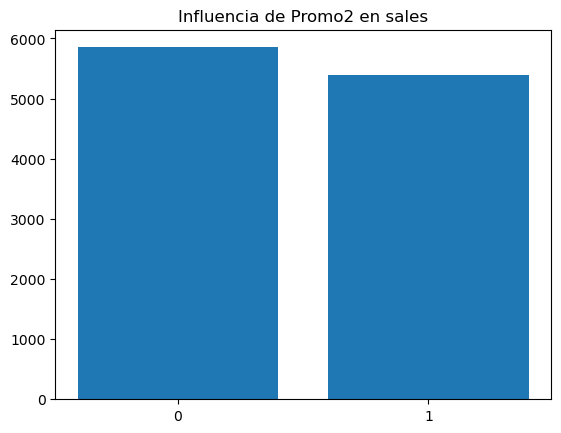

In [240]:
# Como influye Promo2 en Sales
subtabla = promo2.groupby('IsPromo2Month')['Sales'].mean().reset_index()
plt.bar(subtabla['IsPromo2Month'], subtabla['Sales'])
plt.xticks(subtabla['IsPromo2Month'])
plt.title('Influencia de Promo2 en sales')
plt.show()

In [241]:
# Parecería no haber una influencia clara de la promo2 sobre las ventas, pero la sumamos al dataframe
promo2_dicc = dict()
promo2_dicc['Jan,Apr,Jul,Oct'] = [1, 4, 7, 10]
promo2_dicc['Feb,May,Aug,Nov'] = [2, 5, 8, 11]
promo2_dicc['Mar,Jun,Sept,Dec'] = [3, 6, 9, 12]
promo2_dicc[np.nan] = []

df['IsPromo2Month'] = df.apply(lambda row: row['Month'] in promo2_dicc[row['PromoInterval']], axis=1)

df = df.join(yearweek(df, 'Promo2SinceYear', 'Promo2SinceWeek'), how='left', rsuffix='_r').rename(columns={'yearweekfunc': 'YearWeekPromo2'})

df['Promo2Timing'] = df['IsPromo2Month'] & (df['YearWeek'] >= df['YearWeekPromo2'])

In [242]:
# Se hace el mismo procesamiento con el año y mes de la apertura de la competencia
df = df.join(yearweek(df, 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'), how='left', rsuffix='_r').rename(columns={'yearweekfunc': 'MesanioCompetition'})

df['HasCloseCompetition'] = (df['CompetitionDistance'].notna()) & (df['YearWeek'] >= df['MesanioCompetition'])

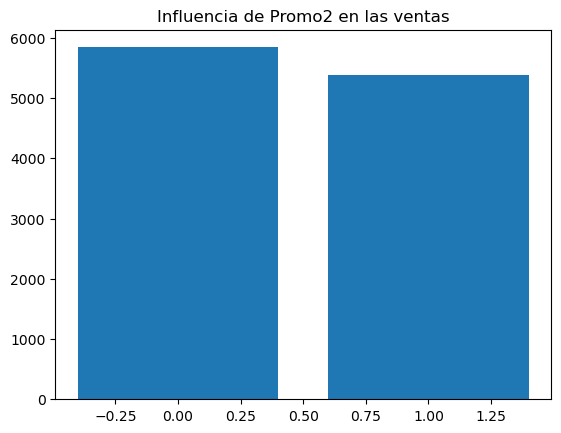

In [243]:
# Probamos lo mismo con la nueva columna de Promo2Timing
subtabla = df[df['Kaggle'] == False].groupby('Promo2Timing')['Sales'].mean().reset_index()
plt.bar(subtabla['Promo2Timing'], subtabla['Sales'])
plt.title('Influencia de Promo2 en las ventas')
# Mismo resultado
plt.show()

In [244]:
check = df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'IsPromo2Month', 'YearWeek', 'YearWeekPromo2',
       'Promo2Timing']].copy()

check[(check['Promo2Timing'] == False) & (check['IsPromo2Month'])]
#Chequeo de que las variables que creamos estan funcionando

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,IsPromo2Month,YearWeek,YearWeekPromo2,Promo2Timing
136457,2015-03-31,1,2015.0,23.0,"Mar,Jun,Sept,Dec",True,201514,201523.0,False
136658,2015-03-31,1,2015.0,23.0,"Mar,Jun,Sept,Dec",True,201514,201523.0,False
136901,2015-03-31,1,2015.0,23.0,"Mar,Jun,Sept,Dec",True,201514,201523.0,False
137572,2015-03-30,1,2015.0,23.0,"Mar,Jun,Sept,Dec",True,201514,201523.0,False
137773,2015-03-30,1,2015.0,23.0,"Mar,Jun,Sept,Dec",True,201514,201523.0,False
...,...,...,...,...,...,...,...,...,...
1017187,2013-01-01,1,2014.0,40.0,"Jan,Apr,Jul,Oct",True,201301,201440.0,False
1017192,2013-01-01,1,2013.0,14.0,"Jan,Apr,Jul,Oct",True,201301,201314.0,False
1017195,2013-01-01,1,2014.0,40.0,"Jan,Apr,Jul,Oct",True,201301,201440.0,False
1017199,2013-01-01,1,2013.0,31.0,"Jan,Apr,Jul,Oct",True,201301,201331.0,False


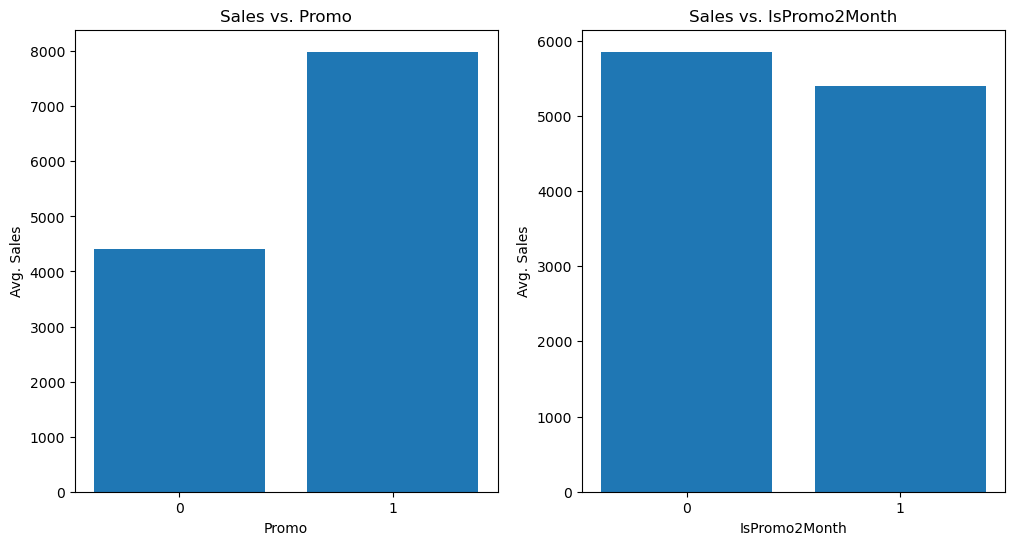

In [245]:
### Gráfico efectividad de promos, diferencia
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Columnas a graficar
cols = ['Promo', 'IsPromo2Month']

# Se recorre las 2 columnas a graficar contra Sales
for i in range(len(cols)):
    subtabla = df[df['Kaggle'] == False].groupby(cols[i])['Sales'].mean().reset_index()
    axs[i].bar(subtabla[cols[i]], subtabla['Sales'])
    axs[i].set_xlabel(cols[i])
    axs[i].set_ylabel('Avg. Sales')
    axs[i].set_xticks(subtabla[cols[i]])
    axs[i].set_title(f'Sales vs. {cols[i]}')

Promo1 parecería ser más efectiva que promo2

### Feature engineering con promo1
- Creación de PromoDaysCount --> Contador de días de promo
- Creación de RecentPromo --> Toma valor de 1 si hubo una promo recientemente

In [246]:
# ## Contador de dias de promo
# Me creo df de copia para hacer operaciones ahi
df_copy = df.copy()

df_copy = df_copy.sort_values(["Store", "Date"]) 
## Calculo de contador de dias de promo seguidos
df_copy["PromoDaysCount"] = df_copy.groupby(["Store", (df_copy["Promo"] == 0).cumsum()])["Promo"].apply(lambda x: (x == 1).cumsum()) 

# agrego la serie calculada al DataFrame original
df["PromoDaysCount"] = df_copy["PromoDaysCount"]

In [247]:
# Creo copia de df y ordeno convenientemente
df_copy = df.copy()
df_copy = df_copy.sort_values(["Store", "Date"]) 


# calculo la suma de Promo en los 2 dias anteriores (es una variable auxiliar)
df_copy["sum_promo"] = (df_copy.groupby("Store")["Promo"].shift(1).rolling(window=2).sum())

# me creo la variable dummy que indica si hubo promo en los dos días anteriores
df_copy["RecentPromo"] = ((df_copy["sum_promo"] > 0) & (df_copy["Promo"] == 0)).astype(int)

df["RecentPromo"] = df_copy["RecentPromo"] #me paso la variable al df

### Incorporación de variables externas
Incorporamos informacion sobre la tasa EURIBOR a 3 meses anualizada
- Para datos futuros se puede asumir el promedio del ultimo mes siempre que se vaya a predecir, ya que la tasa no es muy volatil

In [248]:
euri3m = pd.read_csv(euri3m_id, parse_dates=True, low_memory=False)
eurimonth = pd.read_csv(eurimonth_id, parse_dates=True, low_memory=False)

In [249]:
nombres= {'dundasChartControl1_DRG_DataRowGrouping1_label': 'plazo',
          'dundasChartControl1_DRG_DataRowGrouping1_dundasChartControl1_DCG_Period1_label': 'mes',
          'dundasChartControl1_DRG_DataRowGrouping1_dundasChartControl1_DCG_Period1_Value_X': 'fecha',
          'dundasChartControl1_DRG_DataRowGrouping1_dundasChartControl1_DCG_Period1_Value_Y': 'euriborday'
          }
euri3m = euri3m.rename(columns=nombres)
euri3m['fecha'] = pd.to_datetime(euri3m.apply(lambda row: row['fecha'].split(' ')[0], axis=1), format='%m/%d/%Y')
euri3m.drop(['plazo', 'mes'], axis=1, inplace=True)

In [250]:
eurimonth['date'] = pd.to_datetime(eurimonth['date'])
eurimonth['Year'] = eurimonth['date'].dt.year
eurimonth['Month'] = eurimonth['date'].dt.month
eurimonth['Mesanio'] = eurimonth['Year'].astype(str) + '-' + eurimonth['Month'].apply(lambda x: '0'+str(x) if x <= 9 else str(x))
eurimonth = eurimonth[(eurimonth['Mesanio'] >= '2013-01') & (eurimonth['Mesanio'] <= '2015-12')].copy()
eurimonth.drop(['conf', 'status1', 'comment', 'date', 'Year', 'Month'], axis=1, inplace=True)
eurimonth = eurimonth.rename(columns={'s1': 'euribormonth'})

In [251]:
df = pd.merge(df, eurimonth, how='left', left_on='Mesanio', right_on='Mesanio')
df = pd.merge(df, euri3m, how='left', left_on='Date', right_on='fecha')

In [252]:
df['Euribor'] = np.where(df['euriborday'].notna(), df['euriborday'], df['euribormonth'])
df.drop(['euribormonth', 'fecha', 'euriborday'], axis=1, inplace=True)

Sobre el test set, no podemos tener datos del euribor porque sería hacer "trampa", ya que supuestamente no conocemos cuanto será esta tasa, es por eso, que tomaremos el promedio del mes anterior, ya que la tasa no es lo suficientemente volátil como para que se justifique hacer otra estimación.

In [253]:
last_euribor = df[df['Mesanio'] == '2015-07']['Euribor'].mean()
print(df[df['Mesanio'] == '2015-07']['Euribor'].mean())
df.loc[df['Kaggle'],'Euribor'] = last_euribor

-0.01872903225806408


### Ajustes a algunas variables que fuimos creando

In [254]:
#Convertimos los boolean a int
df['IsWeekend'] = df['IsWeekend'].astype(int)
df['PrimeraQuincena'] = df['PrimeraQuincena'].astype(int)
df['SegundaQuincena'] = df['SegundaQuincena'].astype(int)
df['ComienzaAnio'] = df['ComienzaAnio'].astype(int)
df['TerminaAnio'] = df['TerminaAnio'].astype(int)
df['IsPromo2Month'] = df['IsPromo2Month'].astype(int)
df['Date'] = pd.to_datetime(df['Date']).astype('int64') // 10**9
df['Promo2Timing'] = df['Promo2Timing'].astype(int)
df['HasCloseCompetition'] = df['HasCloseCompetition'].astype(int)
df['Mesanio'] = df['Mesanio'].str.replace('-','').astype(int)


In [255]:
# Convertimos las categorias a int
df['StateHolidayA'] = np.where(df['StateHoliday'] == 'a', 1, 0)
df['StateHolidayB'] = np.where(df['StateHoliday'] == 'b', 1, 0)
df['StateHolidayC'] = np.where(df['StateHoliday'] == 'c', 1, 0)
df.drop('StateHoliday', axis=1, inplace=True)
df['StoreTypeA'] = np.where(df['StoreType'] == 'a', 1, 0)
df['StoreTypeB'] = np.where(df['StoreType'] == 'b', 1, 0)
df['StoreTypeC'] = np.where(df['StoreType'] == 'c', 1, 0)
df.drop('StoreType', axis=1, inplace=True)
df['AssortmentNum'] = np.where(df['Assortment'] == 'a', 1, 0)
df['AssortmentNum'] = np.where(df['Assortment'] == 'b', 2, df['AssortmentNum'])
df['AssortmentNum'] = np.where(df['Assortment'] == 'c', 3, df['AssortmentNum'])
df.drop('Assortment', axis=1, inplace=True)

### Checkpoint de guardado de dataset
Acá vamos a guardar el dataset completo, a partir de acá se realizan divisiones en train, val y test

In [256]:
df.to_pickle('df_checkpoint.pkl')

## Definimos Train, Val y Test
Separamos en la base que info será usada para entrenar y que info será usada para testeo
Es importante hacer esto en este punto del Feature Eng. para poder empezar a hacer las cosas que requieran hacer promedios mirando toda la base sin hacer ***Data Leakage***. Por ejemplo, si se hace un promedio por Store, se deberia hacer sobre el conjunto en entrenamiento solamente, sin incluir la info de testeo para que no influya en la info que ingestara el modelo.

In [257]:
test = df[df['Kaggle']]
train = df[~df['Kaggle']]

In [258]:
#Últimas seis semaanas de los datos como validación
train[['Mesanio', 'Store']].groupby('Mesanio').count()

,Store
Mesanio,
201301,34564
201302,31220
201303,34565
201304,33450
201305,34565
201306,33450
201307,34565
201308,34565
201309,33450


In [259]:
train['TrainSet'] = np.where(train['YearWeek'] <= 201525, True, False)

C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\2037043941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TrainSet'] = np.where(train['YearWeek'] <= 201525, True, False)


### Gestión de nulls: Train

In [260]:
dropear = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear','Id','Kaggle']
# Columnas que directamente podemos dropear, ya que estan representadas de otra forma
#El id y Kaggle es irrelevante ahora
train.drop(dropear, axis=1, inplace=True)

C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\3234139607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(dropear, axis=1, inplace=True)


In [261]:
print(train.isna().sum()) ## Chequeo de NA

Store                       0
DayOfWeek                   0
Date                        0
Sales                       0
Open                        0
Promo                       0
SchoolHoliday               0
CompetitionDistance      2642
Promo2                      0
IsWeekend                   0
Day                         0
PrimeraQuincena             0
Semana                      0
Year                        0
Month                       0
Mesanio                     0
Quarter                     0
DayOfYear                   0
SegundaQuincena             0
ComienzaAnio                0
TerminaAnio                 0
YearWeek                    0
IsPromo2Month               0
YearWeekPromo2         508031
Promo2Timing                0
MesanioCompetition     325048
HasCloseCompetition         0
PromoDaysCount              0
RecentPromo                 0
Euribor                     0
StateHolidayA               0
StateHolidayB               0
StateHolidayC               0
StoreTypeA

##### CompetitionDistance y MesAnioCompetition
Competition Distance y Mes Año Competition estan vacios si no tienen competencia cercana. Mi idea por ahora es fijarles un valor outlier, bastante grande, para que el modelo haga un corte en esa variable que ya de por si haría con HasCloseCompetition. Consultemoslo con el profe igual.

In [262]:
train.loc[train['MesanioCompetition'].isna(),:]['HasCloseCompetition'].unique()
## Son NA si no tienen close competition

array([0])

In [263]:
train.loc[train['CompetitionDistance'].isna(),:]['HasCloseCompetition'].unique()
## Son NA si no tienen close competition

array([0])

In [264]:
max_comp_distance = train['CompetitionDistance'].max()
train.loc[train['CompetitionDistance'].isna(), 'CompetitionDistance'] = max_comp_distance * 1.5
#le pongo una competition distance 50% mayor al maximo, va a ser un outlier y va a realizar cortes que ya realizaria HasCloseCompetition

In [265]:
train.loc[train['MesanioCompetition'].isna(),'MesanioCompetition'] = 0
#Lo mismo, le estoy seteando un outlier porque no tiene competencia cercana.

In [266]:
train['YearWeekPromo2'] = np.where(train['YearWeekPromo2'].notna(), train['YearWeekPromo2'], train['YearWeekPromo2'].median())
#YearWeekPromo2 le asigno la mediana para completar NAs

C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\1502161317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['YearWeekPromo2'] = np.where(train['YearWeekPromo2'].notna(), train['YearWeekPromo2'], train['YearWeekPromo2'].median())


### Gestión de nulls: Test

In [267]:
#Toco un poco la lista de columnas a droppear
dropear.remove('Id')
dropear.append('Sales')

In [268]:
test.drop(dropear, axis=1, inplace=True) #Droppeo columnas irrelevantes

C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\1233876745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(dropear, axis=1, inplace=True) #Droppeo columnas irrelevantes


In [269]:
print(test.isna().sum())

Store                      0
DayOfWeek                  0
Date                       0
Open                      11
Promo                      0
SchoolHoliday              0
Id                         0
CompetitionDistance       96
Promo2                     0
IsWeekend                  0
Day                        0
PrimeraQuincena            0
Semana                     0
Year                       0
Month                      0
Mesanio                    0
Quarter                    0
DayOfYear                  0
SegundaQuincena            0
ComienzaAnio               0
TerminaAnio                0
YearWeek                   0
IsPromo2Month              0
YearWeekPromo2         17232
Promo2Timing               0
MesanioCompetition     15312
HasCloseCompetition        0
PromoDaysCount             0
RecentPromo                0
Euribor                    0
StateHolidayA              0
StateHolidayB              0
StateHolidayC              0
StoreTypeA                 0
StoreTypeB    

### Gestión de nulls variable: Open

In [270]:
test[test['Open'].isna()] #Todos de store 622

,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,Id,CompetitionDistance,Promo2,IsWeekend,...,PromoDaysCount,RecentPromo,Euribor,StateHolidayA,StateHolidayB,StateHolidayC,StoreTypeA,StoreTypeB,StoreTypeC,AssortmentNum
1017688,622,4,1442448000,NaN,1,0,480.0,NaN,0,0,...,4,0,-0.018729,0,0,0,1,0,0,3
1018544,622,3,1442361600,NaN,1,0,1336.0,NaN,0,0,...,3,0,-0.018729,0,0,0,1,0,0,3
1019400,622,2,1442275200,NaN,1,0,2192.0,NaN,0,0,...,2,0,-0.018729,0,0,0,1,0,0,3
1020256,622,1,1442188800,NaN,1,0,3048.0,NaN,0,0,...,1,0,-0.018729,0,0,0,1,0,0,3
1021968,622,6,1442016000,NaN,0,0,4760.0,NaN,0,1,...,0,0,-0.018729,0,0,0,1,0,0,3
1022824,622,5,1441929600,NaN,0,0,5616.0,NaN,0,0,...,0,0,-0.018729,0,0,0,1,0,0,3
1023680,622,4,1441843200,NaN,0,0,6472.0,NaN,0,0,...,0,0,-0.018729,0,0,0,1,0,0,3
1024536,622,3,1441756800,NaN,0,0,7328.0,NaN,0,0,...,0,0,-0.018729,0,0,0,1,0,0,3
1025392,622,2,1441670400,NaN,0,0,8184.0,NaN,0,0,...,0,0,-0.018729,0,0,0,1,0,0,3
1026248,622,1,1441584000,NaN,0,0,9040.0,NaN,0,0,...,0,0,-0.018729,0,0,0,1,0,0,3


In [271]:
#Está abierto todos los días menos domingos
train[(train['Store'] == 622) & (train['Open'] == 0)]['DayOfWeek'].value_counts()

7    134
4      8
1      6
5      6
3      3
2      1
Name: DayOfWeek, dtype: int64

In [272]:
test['Open'] = test['Open'].fillna(1) #Como no hay domingos, asumimos que esta abierto

C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\1494509659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Open'] = test['Open'].fillna(1) #Como no hay domingos, asumimos que esta abierto


#### Los NA de la columna de open corresponden todas a la misma tienda, y por lo que vimos, podemos asumir que esta abierto todos los dias menos **domingo**

### El resto, tengo las mismas columnas con NA, le voy a aplicar el mismo tratamiento

In [273]:
test.loc[test['CompetitionDistance'].isna(), 'CompetitionDistance'] = max_comp_distance * 1.5
#le pongo una competition distance 50% mayor al maximo, va a ser un outlier

In [274]:
test.loc[test['MesanioCompetition'].isna(),'MesanioCompetition'] = 0

In [275]:
test['YearWeekPromo2'] = np.where(test['YearWeekPromo2'].notna(), test['YearWeekPromo2'], test['YearWeekPromo2'].median())

C:\Users\lucas.veteikis\AppData\Local\Temp\ipykernel_8768\2697080494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['YearWeekPromo2'] = np.where(test['YearWeekPromo2'].notna(), test['YearWeekPromo2'], test['YearWeekPromo2'].median())


##### Vamos a exportar los resultados

In [276]:
train.to_pickle('dataset_feat_eng.pkl')
#train.to_pickle('dataset_feat_eng_with_customers.pkl')
test.to_pickle('test_with_feat_eng.pkl')

# Modelado

In [277]:
valid = train[train['TrainSet']==False].copy()
valid.drop(['TrainSet'], axis=1, inplace=True)
train = train[train['TrainSet']].copy()
train.drop(['TrainSet'], axis=1, inplace=True)


In [278]:
print(f'Shape de train: {train.shape}')
print(f'Shape de valid: {valid.shape}')

Shape de train: (972609, 37)
Shape de valid: (44600, 37)


In [279]:
## Split de train y valid
x_train = train.drop(['Sales'],axis=1)
y_train = train['Sales']
x_valid = valid.drop(['Sales'],axis=1)
y_valid = valid['Sales']


## Model Selection
Aca vamos a hacer pruebas con distintos modelos out of the box y comparar cuales son los que mejor se adaptan al problema en cuestion.

In [80]:
### Prueba de modelos out-of-bag para saber por que camino seguir
results = dict()

models = [
    LinearRegression(),
    KNeighborsRegressor(),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    LGBMRegressor(random_state=42),
    xgb.XGBRegressor(random_state=42),
    CatBoostRegressor(verbose=False,random_state=42),
    BaggingRegressor(random_state=42),
    RandomForestRegressor(random_state=42)
]

for model in models:
  model.fit(x_train,y_train)
  y_pred = pd.Series(model.predict(x_valid))
  rmspe_val = rmspe(y_valid, y_pred)
  results[f'{model.__class__.__name__}'] = rmspe_val
  print(f'{model.__class__.__name__} RMSPE: {rmspe_val}')

LinearRegression RMSPE: 0.4656617226588445
KNeighborsRegressor RMSPE: 0.9695154140162074
AdaBoostRegressor RMSPE: 1.210127012942978
DecisionTreeRegressor RMSPE: 0.21804101942293005
GradientBoostingRegressor RMSPE: 0.4311469124590819
LGBMRegressor RMSPE: 0.34941863234066267
XGBRegressor RMSPE: 0.24956216019355354
CatBoostRegressor RMSPE: 0.23766566446886642
BaggingRegressor RMSPE: 0.171624419757097
RandomForestRegressor RMSPE: 0.16623127606616292


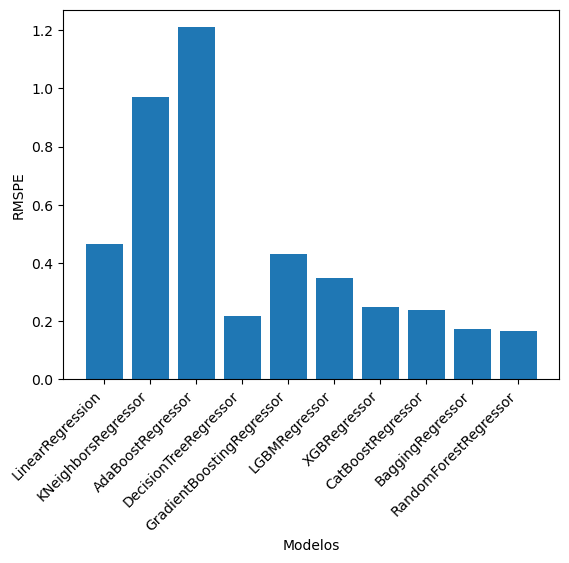

In [81]:
models = list(results.keys())
error = list(results.values())

plt.bar(models,error)
plt.xlabel('Modelos')
plt.ylabel('RMSPE')
plt.xticks(rotation=45,ha='right')
plt.show()

#### Primer modelo a probar: RandomForest

In [82]:
# RANDOM FOREST
# Creamos un diccionario auxiliar que como claves tiene los hiperparametros a variar y como valores tiene una lista con 2 elementos:
# el primero, la funcion del modulo random que hay que utilizar y el segundo, una tupla con los argumentos a pasarle a la funcion
# este es especificamente para RANDOM FOREST
boundaries_rf = dict()
boundaries_rf['n_estimators'] = [random.randint, (500, 800)]
boundaries_rf['criterion'] = [random.choice, (['squared_error'], )] # Otras opciones ya descartadas: friedman_mse y poisson
boundaries_rf['max_depth'] = [random.randint, (50, 150)]
boundaries_rf['min_samples_split'] = [random.randint, (60, 95)]
boundaries_rf['max_features'] = [random.uniform, (0.55, 0.8)]
boundaries_rf['bootstrap'] = [random.choice, ([True], )]
boundaries_rf['max_samples'] = [random.uniform, (0.55, 0.8)]
boundaries_rf['random_state'] = [random.choice, ([42], )]
boundaries_rf['n_jobs'] = [random.choice, ([-1], )]

In [83]:
path_para_guardar = 'rand_search_RandomForest.csv'

random_search_rf, top_models_rf = hyper_search(RandomForestRegressor, 
                                         x_train, y_train, x_valid, y_valid, 
                                         minutos=300, 
                                         hparam_n_samples=n_samples(40, boundaries_rf),
                                         file_path=path_para_guardar)

random_search_rf.reset_index(drop=True, inplace=True)


# Se guarda el dataframe del random search final pisando las versiones intermedias anti-crasheos
random_search_rf.sort_values('rmspe_val').to_csv(path_para_guardar)

Comienza el proceso de random search hasta llegar a 250 modelos o 300 minutos disponibles
Ahora: 2023-07-14 21:36:02.576600
Finalización aproximada: 2023-07-15 02:36:02.575603
Modelo 5 terminado. Quedan 245 modelos por correr o 225 minutos. (2023-07-14 22:50:03.930256)
Modelo 10 terminado. Quedan 240 modelos por correr o 153 minutos. (2023-07-15 00:02:55.245345)
Modelo 15 terminado. Quedan 235 modelos por correr o 73 minutos. (2023-07-15 01:22:56.225254)
Modelo 20 terminado. Quedan 230 modelos por correr o -2 minutos. (2023-07-15 02:38:16.764658)
Se acabo el tiempo el tiempo, se procesaron 20 modelos


#### Análisis de resultados RandomForest

In [84]:
random_search_rf.sort_values('rmspe_val')

,n_estimators,criterion,max_depth,min_samples_split,max_features,bootstrap,max_samples,random_state,n_jobs,rmspe_train,rmspe_val,sesgo_val,ajuste_sesgo,rmspe_val_ajust_sesgo,algoritmo,tiempo_min
18,745,squared_error,115,78,0.701972,True,0.797706,42,-1,0.209108,0.185386,159.311866,0.974113,0.173936,RandomForestRegressor,20.3
4,747,squared_error,105,65,0.732595,True,0.672776,42,-1,0.206354,0.185660,170.860640,0.972236,0.173294,RandomForestRegressor,18.5
5,545,squared_error,147,62,0.771711,True,0.574924,42,-1,0.208401,0.185952,163.564596,0.973422,0.174205,RandomForestRegressor,13.9
9,715,squared_error,109,74,0.761552,True,0.663190,42,-1,0.210186,0.186753,155.310108,0.974763,0.175661,RandomForestRegressor,18.4
0,571,squared_error,140,73,0.754014,True,0.558661,42,-1,0.212418,0.187691,143.437952,0.976692,0.177515,RandomForestRegressor,12.8
1,554,squared_error,102,70,0.671780,True,0.584370,42,-1,0.212038,0.187911,155.945523,0.974660,0.176574,RandomForestRegressor,13.0
8,517,squared_error,96,65,0.567810,True,0.795750,42,-1,0.201576,0.187982,184.186793,0.970071,0.174025,RandomForestRegressor,11.8
6,585,squared_error,108,94,0.790496,True,0.649655,42,-1,0.217612,0.188793,121.636361,0.980235,0.180331,RandomForestRegressor,16.2
15,577,squared_error,143,72,0.609088,True,0.778807,42,-1,0.208665,0.189103,172.304564,0.972002,0.176223,RandomForestRegressor,14.8
11,595,squared_error,108,81,0.724177,True,0.572224,42,-1,0.216121,0.189109,134.184767,0.978196,0.179593,RandomForestRegressor,15.6


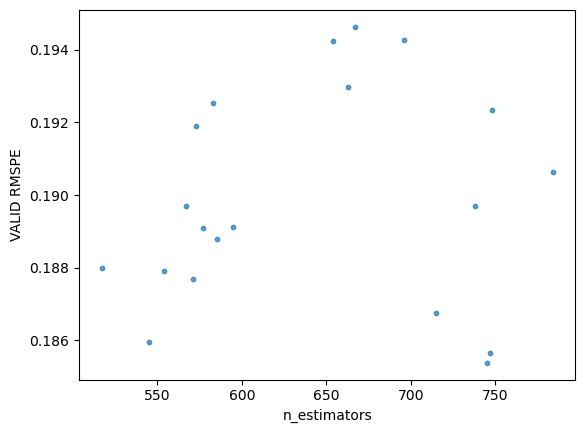

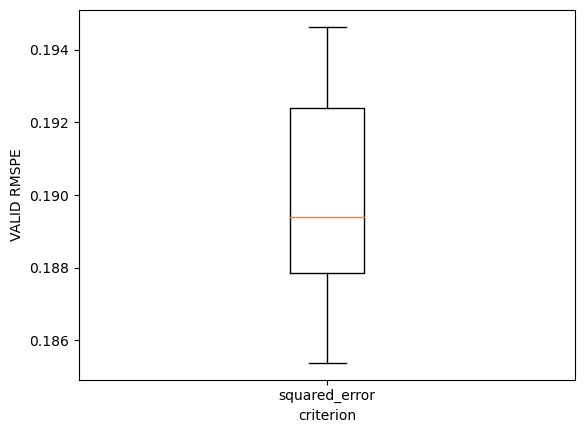

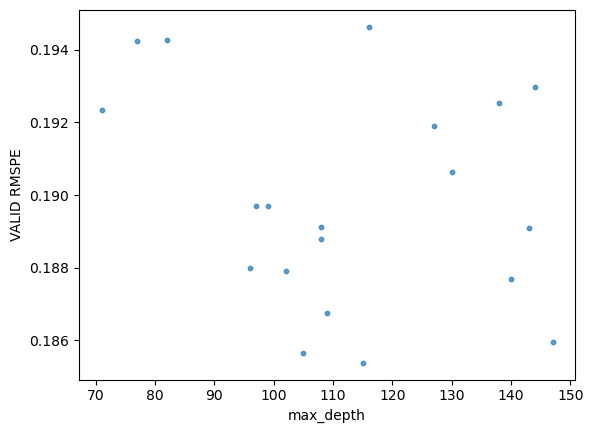

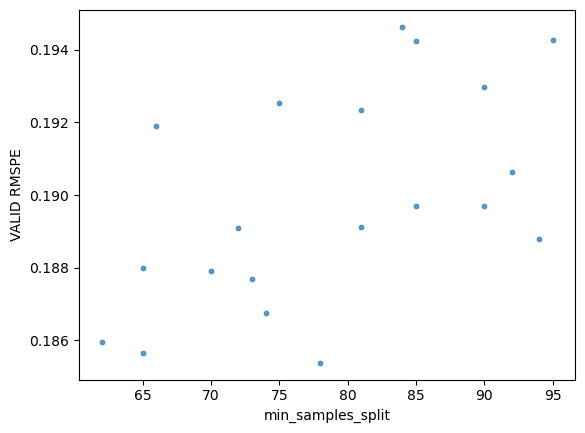

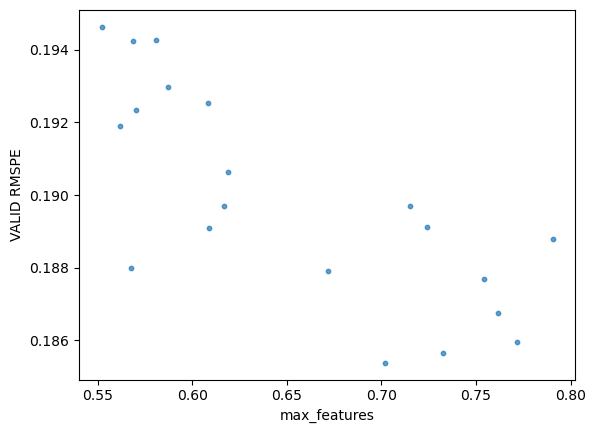

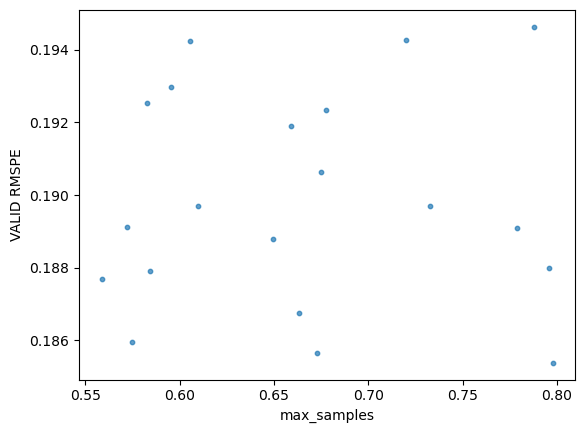

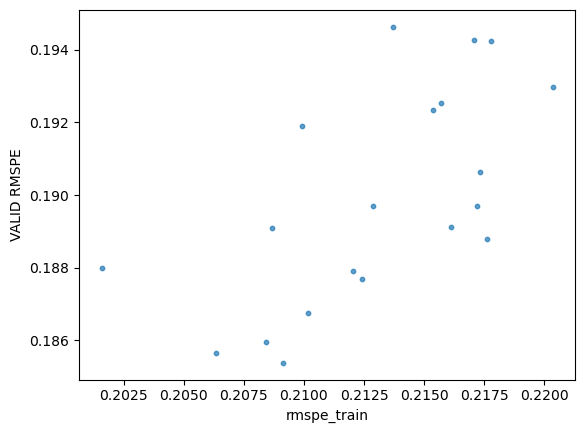

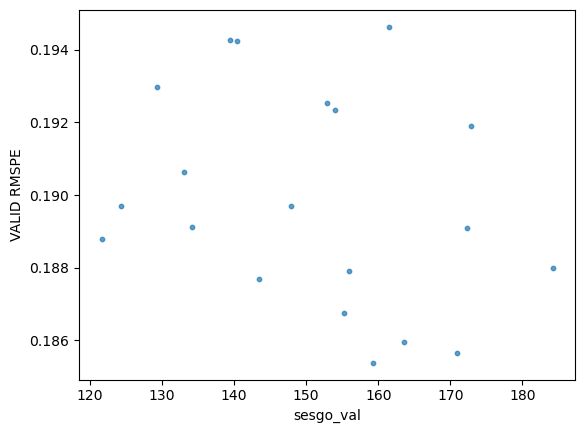

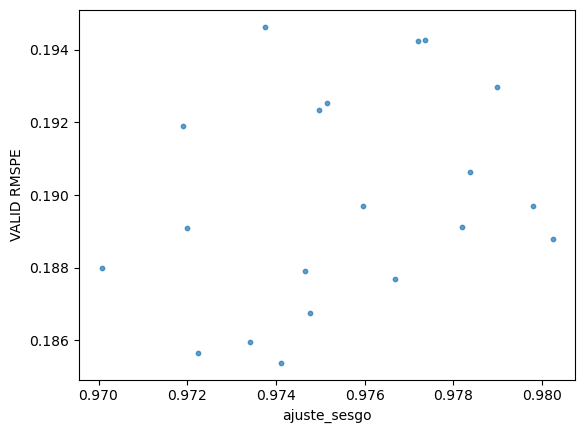

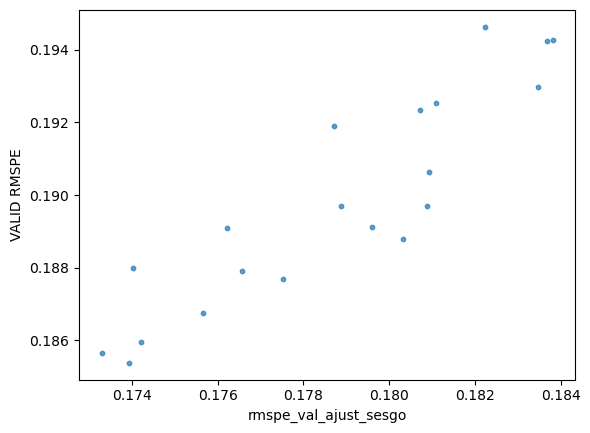

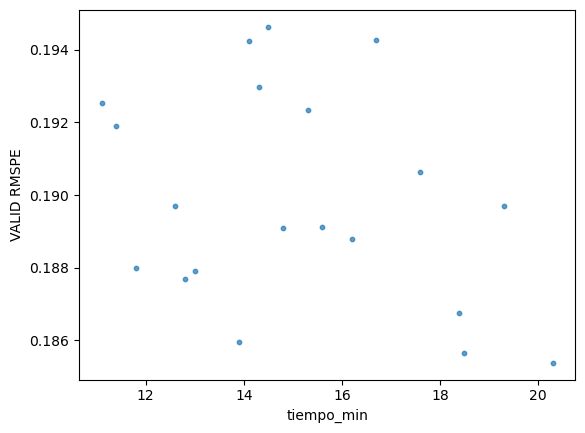

In [85]:
graficar_rand_search(random_search_rf) #Función para graficar

In [86]:
feat_importance(top_models_rf, x_train) ## Evaluamos feature importance a lo largo de todos los modelos

Modelo 0: rmspe en validacion de 0.18769145663556436
Feature Importance
                feature  importance
3                  Open    0.407073
6   CompetitionDistance    0.104992
1             DayOfWeek    0.102594
0                 Store    0.089072
24   MesanioCompetition    0.061410
26       PromoDaysCount    0.054281
4                 Promo    0.042354
22       YearWeekPromo2    0.029785
33           StoreTypeB    0.017640
35        AssortmentNum    0.015323
16            DayOfYear    0.014857
32           StoreTypeA    0.009528
7                Promo2    0.009003
9                   Day    0.008438
34           StoreTypeC    0.006461
11               Semana    0.004777
8             IsWeekend    0.004387
25  HasCloseCompetition    0.003968
2                  Date    0.003417
28              Euribor    0.002443
20             YearWeek    0.001993
29        StateHolidayA    0.001554
13                Month    0.001221
14              Mesanio    0.000983
5         SchoolHoliday    0

### XGBoost
Vamos a probar un segundo modelo, xgboost

In [95]:
## Creamos mismo diccionario que para RandomForest, pero con parametros de xgboost
boundaries_xg = dict()
boundaries_xg['n_estimators'] = [random.randint, (500, 1400)] #Cantidad de arboles
boundaries_xg['learning_rate'] = [random.uniform, (0.01, 0.3)] #ETA
boundaries_xg['max_depth'] = [random.randint, (4, 10)] # Profundidad máx de cada arbol
boundaries_xg['colsample_bytree'] = [random.uniform, (0.8, 0.9)] #% de features a muestrear
boundaries_xg['subsample'] = [random.uniform, (0.7, 0.9)] #% de subsample de la muestra
boundaries_xg['gamma'] = [random.uniform, (0.1, 0.4)] #Reducción minima para particion
boundaries_xg['n_jobs'] = [random.choice, ([-1],)]
boundaries_xg['random_state'] = [random.choice, ([42],)]

In [97]:
path_para_guardar = 'rand_search_XGBoost.csv'

random_search_xg, top_models_xg = hyper_search(XGBRegressor, 
                                         x_train, y_train, x_valid, y_valid, 
                                         minutos=560, 
                                         hparam_n_samples=n_samples(70, boundaries_xg), 
                                         file_path=path_para_guardar)

random_search_xg.reset_index(drop=True, inplace=True)


# Se guarda el dataframe del random search final pisando las versiones intermedias anti-crasheos
random_search_xg.sort_values('rmspe_val').to_csv(path_para_guardar)

Comienza el proceso de random search hasta llegar a 70 modelos o 560 minutos disponibles
Ahora: 2023-07-15 03:17:44.115316
Finalización aproximada: 2023-07-15 12:37:44.113220
Modelo 5 terminado. Quedan 65 modelos por correr o 490 minutos. (2023-07-15 04:27:31.545666)
Modelo 10 terminado. Quedan 60 modelos por correr o 431 minutos. (2023-07-15 05:26:12.073889)
Modelo 15 terminado. Quedan 55 modelos por correr o 384 minutos. (2023-07-15 06:13:28.615882)
Modelo 20 terminado. Quedan 50 modelos por correr o 345 minutos. (2023-07-15 06:52:11.281231)
Modelo 25 terminado. Quedan 45 modelos por correr o 302 minutos. (2023-07-15 07:35:38.815746)
Modelo 30 terminado. Quedan 40 modelos por correr o 260 minutos. (2023-07-15 08:16:46.311461)
Modelo 35 terminado. Quedan 35 modelos por correr o 211 minutos. (2023-07-15 09:06:22.566367)
Modelo 40 terminado. Quedan 30 modelos por correr o 172 minutos. (2023-07-15 09:45:02.161242)
Modelo 45 terminado. Quedan 25 modelos por correr o 123 minutos. (2023-07-

#### Visualización de resultados XGBoost

In [189]:
random_search_xg.sort_values('rmspe_val')

,n_estimators,learning_rate,max_depth,colsample_bytree,subsample,gamma,n_jobs,random_state,rmspe_train,rmspe_val,sesgo_val,ajuste_sesgo,rmspe_val_ajust_sesgo,algoritmo,tiempo_min,best_ntree_limit
52,1387,0.262299,6,0.855580,0.840756,0.217642,-1,42,0.177601,0.143819,142.552240,0.976836,0.136748,XGBRegressor,12.2,1387
21,1268,0.203399,10,0.825222,0.730904,0.296638,-1,42,0.084127,0.152590,99.370748,0.983853,0.149167,XGBRegressor,20.7,1268
2,1209,0.060663,10,0.886189,0.884134,0.186740,-1,42,0.146061,0.155407,236.865987,0.961511,0.140949,XGBRegressor,19.4,1209
4,955,0.180648,8,0.855588,0.860360,0.387464,-1,42,0.156079,0.156121,293.524525,0.952304,0.137235,XGBRegressor,11.4,955
44,791,0.190010,10,0.858730,0.884524,0.341369,-1,42,0.120871,0.157959,277.877617,0.954847,0.140424,XGBRegressor,12.1,791
35,1068,0.278482,7,0.804264,0.812517,0.205062,-1,42,0.169025,0.158663,211.406610,0.965648,0.146720,XGBRegressor,10.5,1068
39,628,0.114325,10,0.846826,0.759753,0.273269,-1,42,0.153072,0.160478,295.688543,0.951953,0.140920,XGBRegressor,10.0,628
13,1044,0.211845,10,0.852330,0.881415,0.123130,-1,42,0.103402,0.160964,264.079719,0.957089,0.144206,XGBRegressor,16.2,1044
8,1046,0.253455,8,0.882563,0.817608,0.397064,-1,42,0.146487,0.161033,210.021004,0.965873,0.147941,XGBRegressor,13.1,1046
43,554,0.199681,7,0.897627,0.710786,0.101154,-1,42,0.188851,0.161823,231.014379,0.962462,0.146913,XGBRegressor,6.1,554


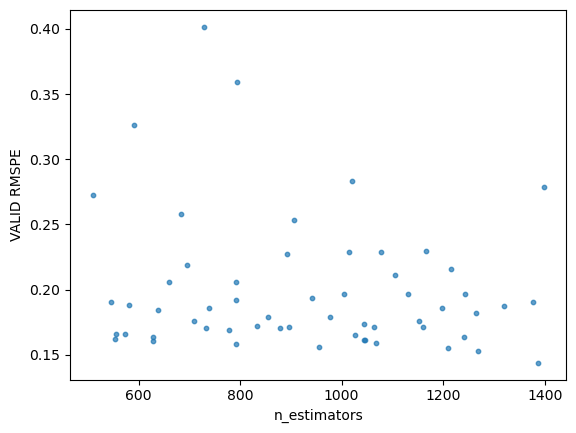

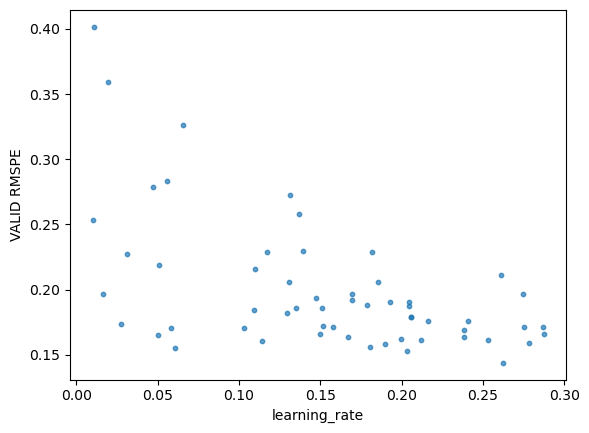

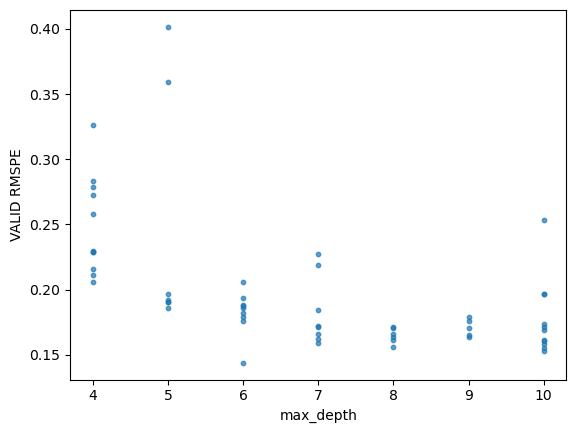

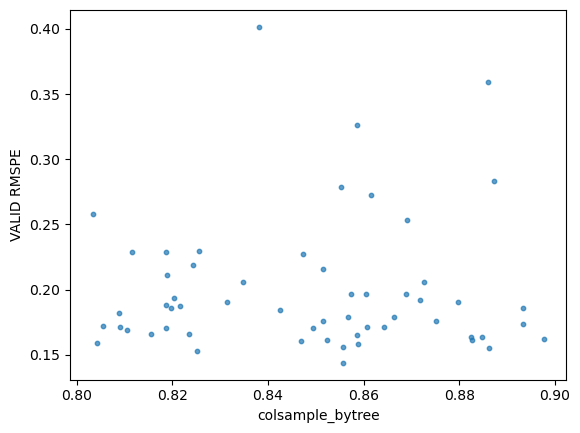

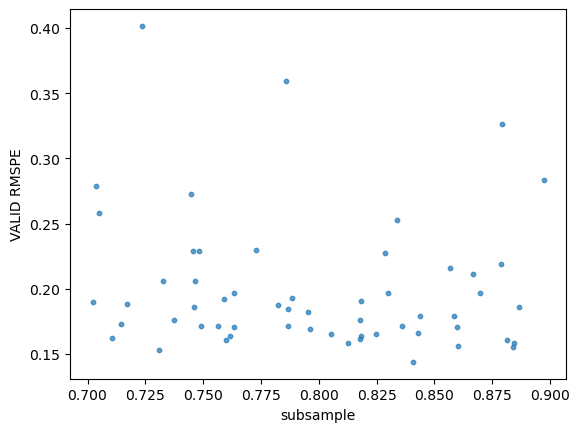

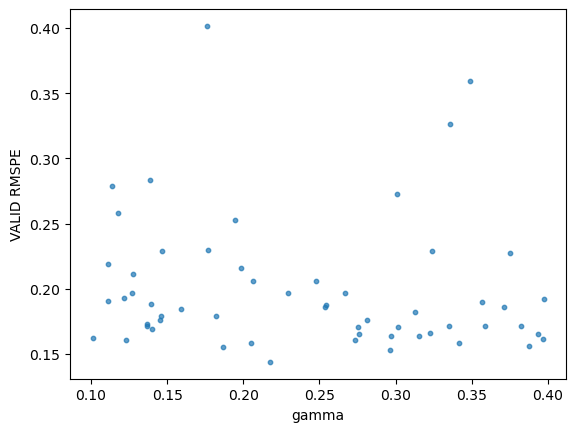

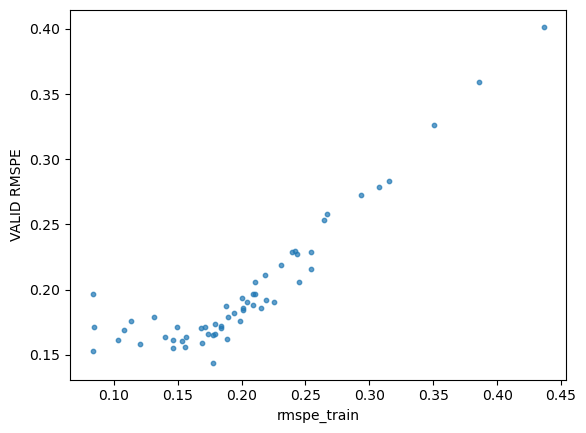

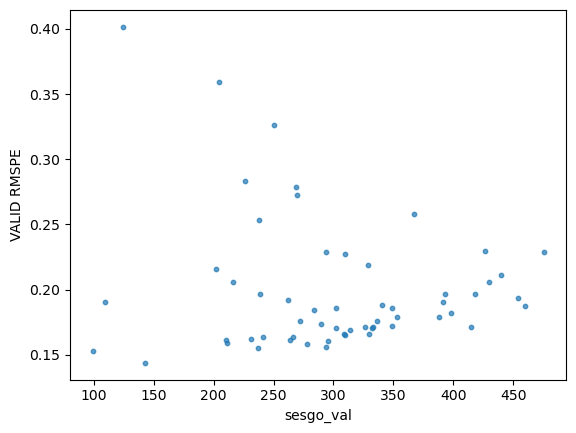

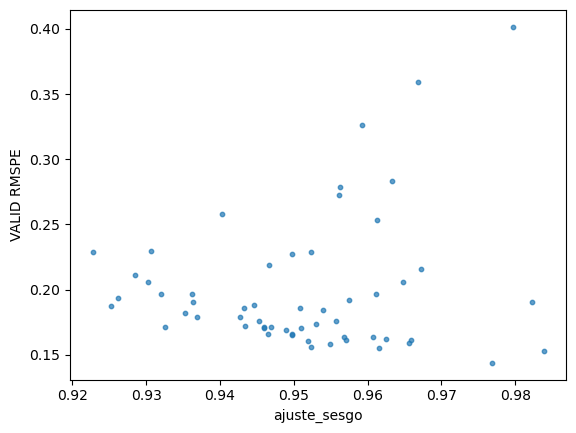

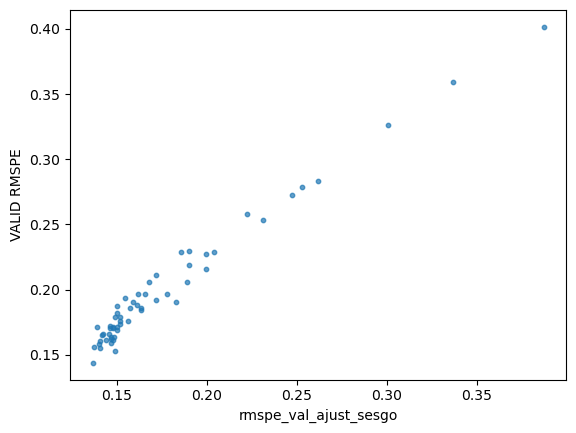

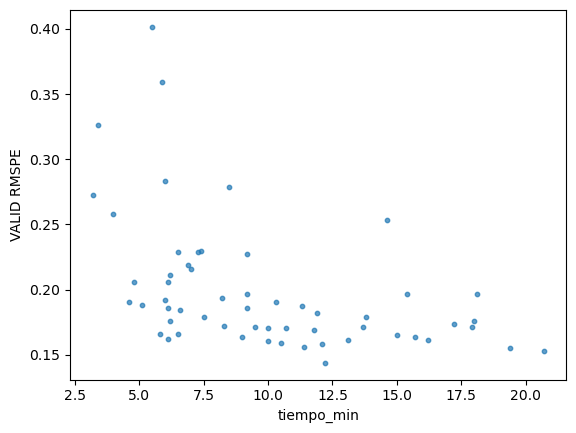

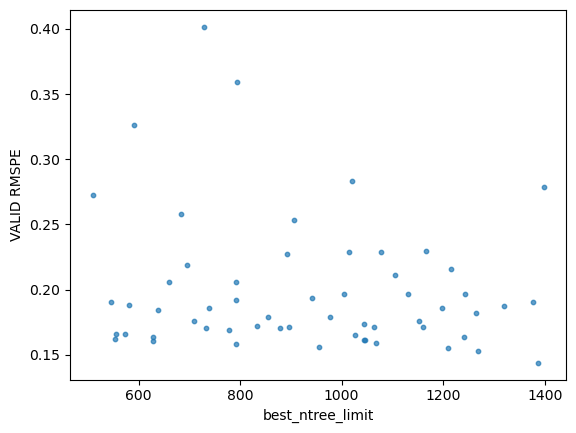

In [190]:
graficar_rand_search(random_search_xg)

In [280]:
feat_importance(top_models_xg,x_train)

Modelo 2: rmspe en validacion de 0.1554071293814821
Feature Importance
                feature  importance
3                  Open    0.296634
33           StoreTypeB    0.136847
29        StateHolidayA    0.092731
31        StateHolidayC    0.091444
4                 Promo    0.070461
30        StateHolidayB    0.052072
1             DayOfWeek    0.026866
35        AssortmentNum    0.025666
7                Promo2    0.024930
26       PromoDaysCount    0.021389
6   CompetitionDistance    0.019239
24   MesanioCompetition    0.018329
32           StoreTypeA    0.017599
0                 Store    0.013878
22       YearWeekPromo2    0.013865
34           StoreTypeC    0.011948
16            DayOfYear    0.007444
15              Quarter    0.006407
19          TerminaAnio    0.006273
25  HasCloseCompetition    0.005827
11               Semana    0.005538
8             IsWeekend    0.005029
9                   Day    0.004693
13                Month    0.004278
14              Mesanio    0.

### Reentrenamiento y predicción

La función de la que se hace uso en esta sección del código reentrena con todos los datos y usa para predecir los modelos que pasen dicho un threshold en el rmspe de validación conseguido, en este caso 0.162. Luego, genera un promedio de todas las predicciones (que probamos que funciona muy bien).

In [287]:
threshold = 0.162
predictions = retrain_and_predict(x_train,y_train,
                                  x_valid,y_valid,
                                  test,top_models_xg,
                                  rmspe_threshold=threshold)

Entrenando modelo 0
Modelo 0 fitteado
Entrenando modelo 1
Modelo 1 fitteado
Entrenando modelo 3
Modelo 3 fitteado
Entrenando modelo 4
Modelo 4 fitteado
Entrenando modelo 6
Modelo 6 fitteado
Entrenando modelo 8
Modelo 8 fitteado
Entrenando modelo 9
Modelo 9 fitteado
Entrenando modelo 12
Modelo 12 fitteado
Entrenando modelo 13
Modelo 13 fitteado
Entrenando modelo 17
Modelo 17 fitteado


##### Dandole formato Kaggle

In [288]:
predictions

0         4600.427246
1         7753.378906
2         9557.230469
3         7846.243652
4         6978.163086
             ...     
41083     2563.262451
41084     6979.963379
41085     5584.905762
41086    21485.648438
41087     7114.632812
Length: 41088, dtype: float32

In [289]:
kaggle = pd.DataFrame(predictions).reset_index()

In [290]:
kaggle.rename(columns={'index':'Id',0:'Sales'},inplace=True)

In [291]:
kaggle['Id'] = kaggle['Id'] + 1

In [292]:
kaggle.to_csv('kaggle.csv',index=False) #Archivo para subir

### Feature importance final
Es el promedio de todos los feature importance de los modelos que usamos para predecir

In [293]:
feature_importance = pd.DataFrame(index=x_train.columns)
for i in range(len(top_models_xg[1])):
    if top_models_xg[2][i] <= threshold:
        feature_importance[f'model{i}']=top_models_xg[1][i].feature_importances_

In [294]:
feature_importance['mean_feature_importance'] = feature_importance.mean(axis=1)

In [295]:
feature_importance = feature_importance.sort_values('mean_feature_importance')

Text(0.5, 0, 'Importancia promedio a lo largo de los modelos')

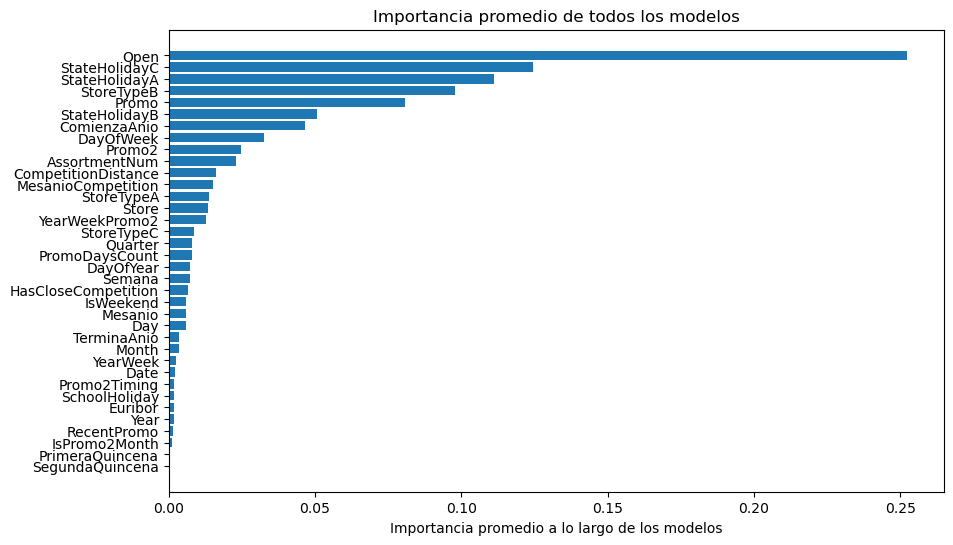

In [296]:
## Plot de importancia promedio de las variables

plt.figure(figsize=(10,6))
plt.barh(feature_importance.index,feature_importance['mean_feature_importance'])
plt.title('Importancia promedio de todos los modelos')
plt.xlabel('Importancia promedio a lo largo de los modelos')

### Problema de Machine Learning adicional

Generamos un problema distinto al inicial. En este caso, será de clasificación donde se buscará predecir si la cantidad de clientes supera un determinado valor (750 clientes) en un día y store determinado.

In [17]:
# Paquetes adicionales
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [18]:
#Volvemos a traernos datasets
train = pd.read_pickle('dataset_feat_eng_with_customers.pkl')

In [19]:
train = train.drop(columns=['Sales'])

In [20]:
train = train[train['Open'] != 0]

In [21]:
# Definir variable categórica a predecir: "CAT_Customers".
# Predeciremos si supera los 750 clientes en el día.

train['CAT_Customers'] = np.where(train['Customers'] >= 750, 1, 0)
train.drop(['Customers'], axis=1, inplace=True)

In [22]:
train.TrainSet.value_counts()

True     805256
False     39136
Name: TrainSet, dtype: int64

In [23]:
valid = train[~train['TrainSet']]
train = train[train['TrainSet']]

In [24]:
# Separamos las X e Y de entrenamiento y validación

x_train = train.drop(['CAT_Customers'], axis=1)
y_train = train['CAT_Customers']
x_test = valid.drop(['CAT_Customers'], axis=1)
y_test = valid['CAT_Customers']

In [27]:
# Corro modelos out of the box

results = dict()

models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    AdaBoostClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    LGBMClassifier(random_state=42),
    XGBClassifier(random_state=42),
    CatBoostClassifier(verbose=False,random_state=42),
    BaggingClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

for model in models:
  model.fit(x_train,y_train)
  y_pred = model.predict_proba(x_test)[:,1]
  auc_score = roc_auc_score(y_test, y_pred)
  results[f'{model.__class__.__name__}'] = auc_score
  print(f'{model.__class__.__name__} AUC Score: {auc_score}')

LogisticRegression AUC Score: 0.4854815308120063
KNeighborsClassifier AUC Score: 0.5661453529244248
AdaBoostClassifier AUC Score: 0.797062327744625
DecisionTreeClassifier AUC Score: 0.8801690072262522
GradientBoostingClassifier AUC Score: 0.8268717916957149
LGBMClassifier AUC Score: 0.932417870153457
XGBClassifier AUC Score: 0.9669998372224773
CatBoostClassifier AUC Score: 0.9764154615933314
BaggingClassifier AUC Score: 0.9659381968902908
RandomForestClassifier AUC Score: 0.9752865834191401


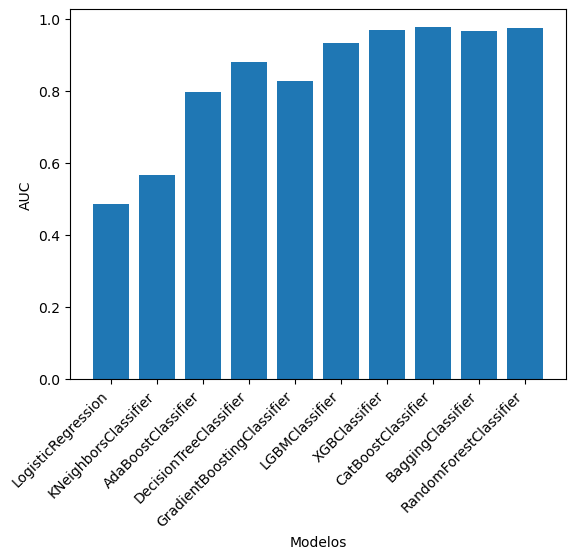

In [28]:
models = list(results.keys())
auc = list(results.values())

plt.bar(models,auc)
plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.xticks(rotation=45,ha='right')
plt.show()

**El mejor modelo "out of the box" corresponde a CatBoost y Random Forest con 0.97 de AUC en el conjunto de validación.**